In [19]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin,cos
from scipy.integrate import solve_ivp

### Define system constants:

In [20]:
omega = 4
Lambda = 4

### Define system DEs as function:

In [21]:
def quantum_model(t, x):  
        
    return [
        -omega*Lambda* (x[0]*x[2])**0.5 *cos(x[3])*(sin(x[1])),  # d(I_e)/dt
        omega -0.5*omega*Lambda* (x[2]/x[0])**0.5 *(cos(x[3])*cos(x[1])),  # d(phi_e)/dt
        2*omega*x[4]*Lambda* (x[0]*x[2])**0.5 *(cos(x[1])*sin(x[3])),  # d(I_m)/dt
        omega*x[4]*Lambda* (x[0]/x[2])**0.5 *(cos(x[3])*cos(x[1])),  # d(phi_m)/dt
        -Lambda* (x[0]*x[2])**0.5 *(cos(x[1])*sin(x[3]))  # d(n)/dt
    ]

### Define time range and initial conditions:

In [33]:
dt = 0.001
t_test = np.arange(0,50,dt)
X0 = [0.5, 0.5, 0.5, 0.5, 1]

### Solve our equations using solve_ivp

In [34]:
sol = solve_ivp(quantum_model, (t_test[0], t_test[-1]), X0, method='BDF', t_eval=t_test) # Integrate
x_test = np.transpose(sol.y)

### Plot:

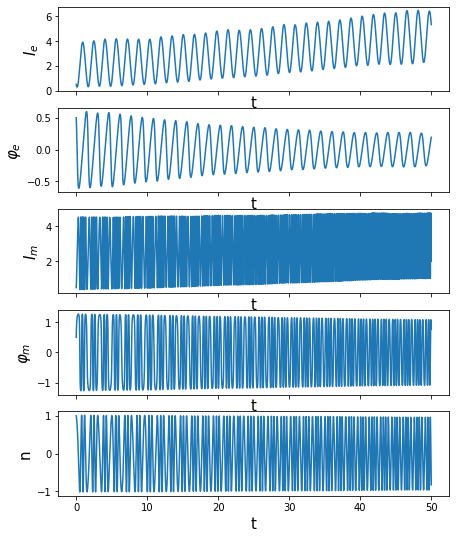

In [35]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7,9))
plt.rc('axes', labelsize=15)
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i])
    axs[i].set(xlabel='t', ylabel=['$I_e$','$\u03C6_e$','$I_m$','$\u03C6_m$', 'n'][i])
    #axs[i].set_xlim(10,11)

## Lyapunov (Benettin) Algorithm

### Set paramaters:

In [29]:
epsilon = 0.01  # Pertibation Amplitude
T = 0.5  # Integral time interval
M = 200  # Integral iterations
N = 5 # Number of state variables in our system
dt = 0.001

### Set up vectors/matrices:

In [30]:
# Reference vector:
x = X0

# Perturbed vector:
x_tilda = np.zeros((N,N))

# Perturned vector relative to reference vector
x_tilda_r = np.zeros((N,N))

# Create initial Orthonormalised perturbed vector:
p = ([[epsilon, 0, 0, 0, 0],
      [0, epsilon, 0, 0, 0],
      [0, 0, epsilon, 0, 0],
      [0, 0, 0, epsilon, 0],
      [0, 0, 0, 0, epsilon]])

x_tilda_0 = [np.add(x,p[0]),
             np.add(x,p[1]),
             np.add(x,p[2]),
             np.add(x,p[3]),
             np.add(x,p[4])]

x_tilda_0_r = np.zeros((N,N))

S = np.zeros(N)

In [31]:
for i in range(M):
    # Integrate reference vector over time T:
    sol = solve_ivp(quantum_model, (i*T, (i+1)*T), x, method='BDF')
    x = (np.transpose(sol.y))[-1]     
    
    for j in range(N):
        # Integrate each perturbation vector over time T:
        # x_tilda(j) = final value of integral from (x_tilda_0(j)) over T
        sol = solve_ivp(quantum_model, (i*T, (i+1)*T), x_tilda_0[j], method='BDF')
        x_tilda[j] = (np.transpose(sol.y))[-1]
        
        # Find the relative vector between each perturbation vector and the refernce vector:
        x_tilda_r[j] = x_tilda[j] - x
            
    # Complete a gram schmidt orthogonalization process on relative perturbed vectors:  
    for j in range(N):
        for k in range(j):
            x_tilda_r[j] = x_tilda_r[j] - (np.dot(x_tilda_r[k], x_tilda_r[j])/np.dot(x_tilda_r[k], x_tilda_r[k])) * x_tilda_r[k]
            
        # Update the accumulated sums with the new relative vector:
        S[j] = S[j] + np.log(np.linalg.norm(x_tilda_r[j]/epsilon))
        
        x_tilda_0_r[j] = x_tilda_r[j] * epsilon / np.linalg.norm(x_tilda_r[j])
        
        # Compute the absolute vectors for the next iteration:
        x_tilda_0[j] = x + x_tilda_0_r[j]

In [32]:
L_exp = S/(M*T)
print(L_exp)

[ 2.4246344   1.36047748  0.50433419 -0.29624941 -2.64840315]
